# Building the EchoScope Model - 2

In [11]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import seaborn as sns
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
IQ_Processed = np.load('../data/processed_iq_data.npz')
Spectrogram_Processed = np.load('../data/spectrograms.npz')

# Training our I/Q Branch

In [25]:
mod_to_group = {
    'QAM16': 'QAM',
    'QAM64': 'QAM',
    'BPSK': 'PSK',
    'QPSK': 'PSK',
    '8PSK': 'PSK',
    'AM-DSB': 'AM',
    'AM-SSB': 'AM',
    'CPFSK': 'FSK',
    'GFSK': 'FSK',
    'WBFM': 'FM',
    'PAM4': 'PAM',
}

unique_groups = sorted(set(mod_to_group.values()))
group_to_idx = {group: i for i, group in enumerate(unique_groups)}
print(f"Group map: {group_to_idx}")
X_list = []
y_list = []

for key_str in IQ_Processed.files:
    key = ast.literal_eval(key_str)
    mod_name = key[0]
    data = IQ_Processed[key_str]

    X_list.append(data)
    y_list.extend([mod_name] * data.shape[0])
X = np.vstack(X_list)    
X = X.transpose(0, 2, 1)
print("X shape:", X.shape) 
y = np.array(y_list)
y_grouped = np.array([mod_to_group.get(mod, 'Unknown') for mod in y])

print(f'Total samples: {X.shape[0]}')
print(f'Unique original modulations: {np.unique(y)}')
print(f'Unique grouped modulations: {np.unique(y_grouped)}')
le_group = LabelEncoder()
y_grouped_enc = le_group.fit_transform(y_grouped)

print(f'Group label classes: {le_group.classes_}')

Group map: {'AM': 0, 'FM': 1, 'FSK': 2, 'PAM': 3, 'PSK': 4, 'QAM': 5}
X shape: (220000, 128, 2)
Total samples: 220000
Unique original modulations: ['8PSK' 'AM-DSB' 'AM-SSB' 'BPSK' 'CPFSK' 'GFSK' 'PAM4' 'QAM16' 'QAM64'
 'QPSK' 'WBFM']
Unique grouped modulations: ['AM' 'FM' 'FSK' 'PAM' 'PSK' 'QAM']
Group label classes: ['AM' 'FM' 'FSK' 'PAM' 'PSK' 'QAM']


### Mapping 11 Modulation Classes into 6 Groups
The original dataset includes 11 distinct modulation types, but due to inconsistencies in class distribution and a desire for broader generalization, I chose to map them into 6 grouped categories:

QAM16, QAM64: QAM

BPSK, QPSK, 8PSK: PSK

AM-DSB, AM-SSB: AM

CPFSK, GFSK: FSK

WBFM: FM

PAM4: PAM

This grouping helps:

Normalize class imbalance and reduce noise from overly fine-grained distinctions.

Improve model generalization and simplify interpretation.

Resolve inconsistencies found across various samples in the dataset (overlap in characteristics between certain modulations).

The grouped labels are then encoded numerically for model training using LabelEncoder. 

In [26]:
def split_sets(X, y):
    X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)
    
    print(f'Train shape: {X_train.shape}, {y_train.shape}')
    print(f'Validation shape: {X_val.shape}, {y_val.shape}')
    print(f'Test shape: {X_test.shape}, {y_test.shape}')
    return X_train, y_train, X_val, y_val, X_test, y_test

In [27]:
y_grouped = np.array([mod_to_group.get(mod, 'Unknown') for mod in y])
le_group = LabelEncoder()
le_group.fit(y_grouped)

X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y_grouped)

y_train_enc = le_group.transform(y_train)
y_val_enc = le_group.transform(y_val)
y_test_enc = le_group.transform(y_test)

print(f'Classes: {le_group.classes_}')
np.save("class_names.npy", le_group.classes_)


Train shape: (132000, 128, 2), (132000,)
Validation shape: (44000, 128, 2), (44000,)
Test shape: (44000, 128, 2), (44000,)
Classes: ['AM' 'FM' 'FSK' 'PAM' 'PSK' 'QAM']


Here we split our data into training/validation/testing sets.

In [28]:
import os
os.makedirs("saved_samples/iq_samples", exist_ok=True)

for i in range(10):
    sample = X_test[i]
    print(sample.shape)
    np.save(f"saved_samples/iq_samples/sample_{i}.npy", sample)

print("Saved 10 I/Q samples to 'saved_samples/iq_samples/'")

(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
(128, 2)
Saved 10 I/Q samples to 'saved_samples/iq_samples/'


In [29]:
X_time_train = X_train.copy()
X_time_val = X_val.copy()
X_time_test = X_test.copy()

y_time_train_enc = y_train_enc.copy()
y_time_val_enc = y_val_enc.copy()
y_time_test_enc = y_test_enc.copy()

Let's save some I/Q examples to be tested by our fusion model later. 

In [30]:
train_dataset_time = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_time = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_time = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_time = DataLoader(train_dataset_time, batch_size=64, shuffle=True)
val_loader_time = DataLoader(val_dataset_time, batch_size=64, shuffle=False)
test_loader_time = DataLoader(test_dataset_time, batch_size=64, shuffle=False)

In [31]:
class Time_Series_Model(nn.Module):
    def __init__(self, input_size=2, hidden_size=256, output_size=6, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )
        self.bn = nn.BatchNorm1d(hidden_size*2)
        self.fc1 = nn.Linear(hidden_size*2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        out = self.bn(last_out)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

## Time_Series_Model: Bidirectional LSTM for IQ Data

This model is designed to process raw IQ (in-phase/quadrature) signal data using a bi-directional LSTM architecture. It takes in sequences of shape (batch_size, time_steps, 2) and outputs a classification across 6 grouped modulation categories.

Architecture Overview:
Bidirectional LSTM: Captures temporal dependencies from both forward and backward directions. This helps the model understand full signal context.

Batch Normalization: Applied to the final time-step output to stabilize and accelerate training.

Fully Connected Layers: Two dense layers project the temporal encoding into the final class space.

Dropout: Used after the first dense layer to prevent overfitting (through multiple trials, overfitting didn't really become the largest issue, so a value of 0.5 was settled on, contrary to higher ones like 0.7 you may see later on).

Key Configurations:
input_size=2: Each timestep contains 2 features (I and Q).

hidden_size=256: LSTM hidden dimension per direction (so output becomes 512 due to bidirectionality).

num_layers=2: Stacked LSTMs for deeper temporal modeling.

output_size=6: Number of grouped modulation classes (QAM, PSK, AM, other).

This model serves as the time-series analysis backbone of EchoScope and is trained using preprocessed IQ data sequences. The final prediction is made from the last time-step's context vector after passing through normalization and dense layers.

In [32]:
def set_seed(seed=1):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

In [33]:
import copy
def train_model(model, criterion, optimizer, epochs, train_loader, val_loader, patience=5, scheduler=None):
    best_val_loss = float('inf')
    best_model_state = None
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            train_bar.set_postfix(loss=loss.item())
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for X_batch, y_batch in val_bar:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                val_bar.set_postfix(loss=loss.item())
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("LR", optimizer.param_groups[0]['lr'], epoch)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= patience:
                print(f"Early stopping at epoch {epoch} (best val loss: {best_val_loss:.6f})")
                break
        if scheduler:
            scheduler.step(val_loss)
            
    model.load_state_dict(best_model_state)
    return train_losses, val_losses

Here's how our training loop is outlined, nothing special.

In [34]:
Time_Series_Model_V1 = Time_Series_Model()
Time_Series_Model_V1 = Time_Series_Model_V1.to(device)

In [35]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(Time_Series_Model_V1.parameters(), lr=5e-4, weight_decay=1e-4)

Unlike our Spectrogram model, Sklearn's balanced class weights were suprisingly the most accurate for this model. 

##### Now let's train!

In [14]:
train_losses, val_losses = train_model(model=Time_Series_Model_V1, 
                                       criterion=loss_fn, 
                                       optimizer=optimizer, 
                                       epochs=50, 
                                       train_loader=train_loader_time, 
                                       val_loader=val_loader_time)

Epoch 1/50 | Train Loss: 1.418393 | Val Loss: 1.217685


Epoch 2/50 | Train Loss: 1.183030 | Val Loss: 1.164894


Epoch 3/50 | Train Loss: 1.054364 | Val Loss: 1.033972


Epoch 4/50 | Train Loss: 0.985839 | Val Loss: 0.983016


Epoch 5/50 | Train Loss: 0.962651 | Val Loss: 0.948522


Epoch 6/50 | Train Loss: 0.949495 | Val Loss: 0.954663


Epoch 7/50 | Train Loss: 0.938108 | Val Loss: 0.937084


Epoch 8/50 | Train Loss: 0.930771 | Val Loss: 0.922380


Epoch 9/50 | Train Loss: 0.923685 | Val Loss: 0.946866


Epoch 10/50 | Train Loss: 0.918302 | Val Loss: 0.935818


Epoch 11/50 | Train Loss: 0.915082 | Val Loss: 0.931107


Epoch 12/50 | Train Loss: 0.909766 | Val Loss: 0.918942


Epoch 13/50 | Train Loss: 0.905939 | Val Loss: 0.912436


Epoch 14/50 | Train Loss: 0.904685 | Val Loss: 0.933405


Epoch 15/50 | Train Loss: 0.901954 | Val Loss: 0.908034


Epoch 16/50 | Train Loss: 0.897615 | Val Loss: 0.912639


Epoch 17/50 | Train Loss: 0.897210 | Val Loss: 0.903858


Epoch 18/50 | Train Loss: 0.895349 | Val Loss: 0.901811


Epoch 19/50 | Train Loss: 0.893112 | Val Loss: 0.911048


Epoch 20/50 | Train Loss: 0.889930 | Val Loss: 0.911287


Epoch 21/50 | Train Loss: 0.891270 | Val Loss: 0.901018


Epoch 22/50 | Train Loss: 0.888431 | Val Loss: 0.917093


Epoch 23/50 | Train Loss: 0.886468 | Val Loss: 0.902865


Epoch 24/50 | Train Loss: 0.883947 | Val Loss: 0.909214


Epoch 25/50 | Train Loss: 0.882729 | Val Loss: 0.900943


Epoch 26/50 | Train Loss: 0.881785 | Val Loss: 0.900001


Epoch 27/50 | Train Loss: 0.881875 | Val Loss: 0.908759


Epoch 28/50 | Train Loss: 0.879793 | Val Loss: 0.912832


Epoch 29/50 | Train Loss: 0.876989 | Val Loss: 0.895906


Epoch 30/50 | Train Loss: 0.875574 | Val Loss: 0.901216


Epoch 31/50 | Train Loss: 0.875939 | Val Loss: 0.906540


Epoch 32/50 | Train Loss: 0.874500 | Val Loss: 0.900335


Epoch 33/50 | Train Loss: 0.872687 | Val Loss: 0.901527


Epoch 34/50 | Train Loss: 0.872024 | Val Loss: 0.904579
Early stopping at epoch 34 (best val loss: 0.895906)


### LSTM Training Log (Epochs 1–34)
A few key observations about our I/Q branches' training statistics:

#### Early Improvements:
Rapid convergence is seen in the first 5–8 epochs, with a sharp drop in both training and validation loss.

This suggests the model quickly learns the dominant patterns in the IQ data during initial training.

#### Stabilization:
Around epoch 10, the rate of improvement slows down, and the model enters a more stable training regime.

Training and validation loss values begin to plateau in the 0.87–0.91 range.

#### Generalization:
No signs of overfitting are apparent in this segment. Validation loss does not rise significantly, indicating that the model retains generalization ability over time.

##### The occasional small bumps in validation loss (e.g., epoch 14, 19, 28) are expected due to stochasticity in training, but the overall trend remains consistent.

In [14]:
def evaluate_model(model, data_loader, device, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    print(f'Accuracy: {acc:.4f}')
    print('Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))
    return all_labels, all_preds 
    

In [16]:
y_true, y_pred = evaluate_model(Time_Series_Model_V1, test_loader_time, device, le_group)

Accuracy: 0.6581
Classification Report:
              precision    recall  f1-score   support

          AM       0.39      0.93      0.55      8000
          FM       0.58      0.26      0.36      4000
         FSK       0.89      0.62      0.73      8000
         PAM       0.79      0.71      0.75      4000
         PSK       0.91      0.56      0.69     12000
         QAM       0.89      0.74      0.81      8000

    accuracy                           0.66     44000
   macro avg       0.74      0.64      0.65     44000
weighted avg       0.77      0.66      0.67     44000



The model achieved an overall accuracy of 65.81% on the test set. While there's room for improvement, this is a solid result given the complexity of the task and the noisy nature of raw IQ data.

Looking at the per-class performance, the model performs particularly well on QAM, PAM, and FSK, with strong precision and F1-scores. However, classes like FM and AM show some imbalance: AM has high recall but low precision, indicating it's frequently over-predicted, while FM has lower recall, suggesting the model struggles to confidently identify it.

Sadly, tweaking our class weights only decreased the general accuracy given that bumping up FM weights only siphoned more from AM than vice versa. We'll stick with Sklearn's weights

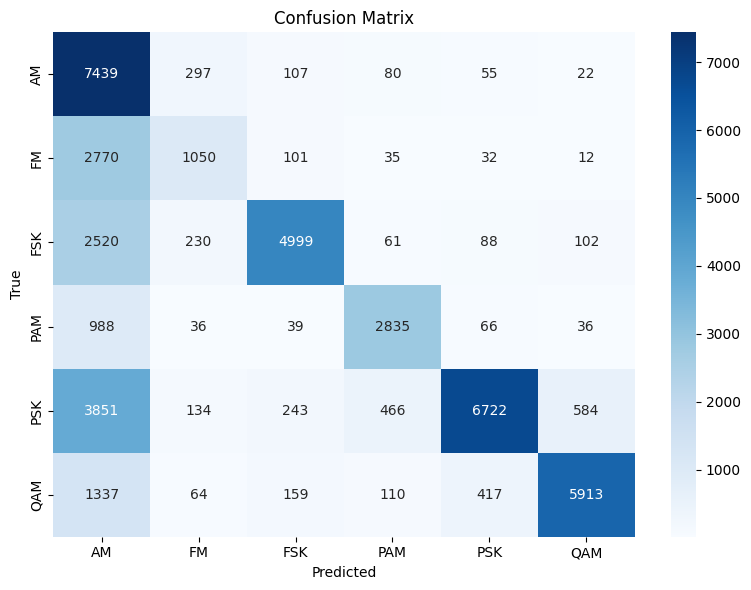

In [17]:
cm = confusion_matrix(y_true, y_pred)
class_names = le_group.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### CONFUSION MATRIX FOR TIME SERIES MODEL

In [103]:
torch.save(Time_Series_Model_V1.state_dict(), 'ts_model_full.pth')

# Training our Spectrogram Branch

In [36]:
keys = Spectrogram_Processed.files
print(keys)

key_example = "('QPSK', 2)"
if key_example in keys:
    data = Spectrogram_Processed[key_example]
    print(f"Data shape for {key_example}:", data.shape)
else:
    print(f"{key_example} not found in the file.")

["('QPSK', 2)", "('PAM4', 8)", "('AM-DSB', -4)", "('GFSK', 6)", "('QAM64', 8)", "('AM-SSB', 12)", "('8PSK', 8)", "('8PSK', 12)", "('QAM64', -6)", "('QAM16', 2)", "('QAM16', -20)", "('PAM4', -6)", "('WBFM', -18)", "('AM-DSB', 16)", "('CPFSK', 10)", "('WBFM', 6)", "('BPSK', 4)", "('BPSK', -2)", "('QPSK', -20)", "('CPFSK', -8)", "('AM-SSB', 6)", "('QAM64', -20)", "('QAM16', 12)", "('GFSK', -20)", "('AM-SSB', -12)", "('CPFSK', 0)", "('AM-DSB', 6)", "('BPSK', -16)", "('QPSK', -6)", "('8PSK', -12)", "('CPFSK', -18)", "('BPSK', -10)", "('QPSK', 8)", "('PAM4', 14)", "('AM-DSB', -10)", "('GFSK', 12)", "('QAM64', 2)", "('WBFM', -4)", "('AM-SSB', -18)", "('QAM64', -4)", "('GFSK', -4)", "('AM-DSB', 8)", "('PAM4', -16)", "('QPSK', -16)", "('BPSK', 16)", "('8PSK', -8)", "('CPFSK', 16)", "('WBFM', 0)", "('QPSK', 6)", "('BPSK', 14)", "('AM-DSB', -8)", "('GFSK', -10)", "('CPFSK', -2)", "('AM-SSB', 8)", "('GFSK', 18)", "('QAM16', 6)", "('QAM16', -16)", "('QAM64', 18)", "('AM-SSB', -2)", "('CPFSK', 6)", 

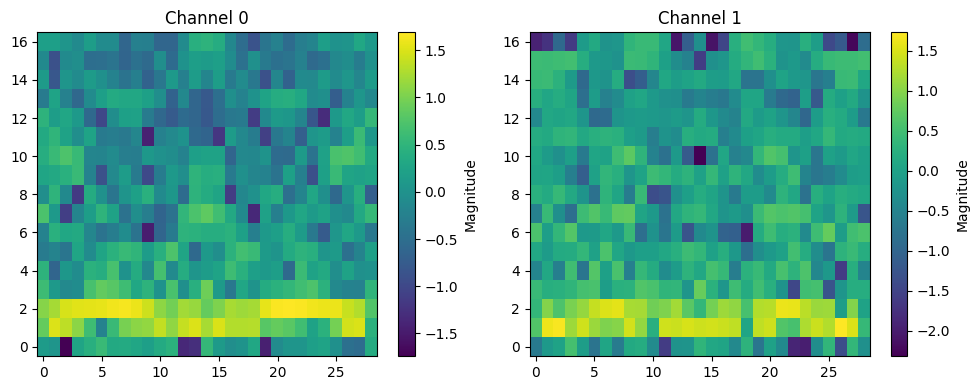

In [37]:
example = data[0] 
plt.figure(figsize=(10,4))
for ch in range(example.shape[0]):
    plt.subplot(1, 2, ch+1)
    plt.title(f'Channel {ch}')
    plt.imshow(example[ch], aspect='auto', origin='lower')
    plt.colorbar(label='Magnitude')
plt.tight_layout()
plt.show()

In [38]:
mod_to_group = {
    'QAM16': 'QAM',
    'QAM64': 'QAM',
    'BPSK': 'PSK',
    'QPSK': 'PSK',
    '8PSK': 'PSK',
    'AM-DSB': 'AM',
    'AM-SSB': 'AM',
    'CPFSK': 'FSK',
    'GFSK': 'FSK',
    'WBFM': 'FM',
    'PAM4': 'PAM',
}
unique_groups = sorted(set(mod_to_group.values()))
group_to_idx = {group: i for i, group in enumerate(unique_groups)}

print(f"Group map: {group_to_idx}")

Group map: {'AM': 0, 'FM': 1, 'FSK': 2, 'PAM': 3, 'PSK': 4, 'QAM': 5}


Just like with our I/Q data, we map our Spectrograms to 6 larger modulation groups.

In [39]:
all_data_spect = []
all_labels_spect = []

keys_tuples = [eval(k) if isinstance(k, str) else k for k in Spectrogram_Processed.keys()]

for key in keys_tuples:
    modulation = key[0]
    group = mod_to_group[modulation]
    str_key = str(key)
    data = Spectrogram_Processed[str_key]
    all_data_spect.append(data)

    label_idx = group_to_idx[group]
    labels = np.full(data.shape[0], label_idx)
    all_labels_spect.append(labels)

X = np.concatenate(all_data_spect, axis=0)
y = np.concatenate(all_labels_spect, axis=0)

print(f"Combined data shape: {X.shape}")
print(f"Combined labels shape: {y.shape}")

Combined data shape: (220000, 2, 17, 29)
Combined labels shape: (220000,)


In [40]:
os.makedirs("saved_samples/spectrogram_samples", exist_ok=True)

for i in range(10):
    sample = X[i]
    np.save(f"saved_samples/spectrogram_samples/sample_{i}.npy", sample)

print("Saved 10 spectrogram samples to 'saved_samples/spectrogram_samples/'")

Saved 10 spectrogram samples to 'saved_samples/spectrogram_samples/'


### Alright, let's visualize some compressions of our spectrogram data

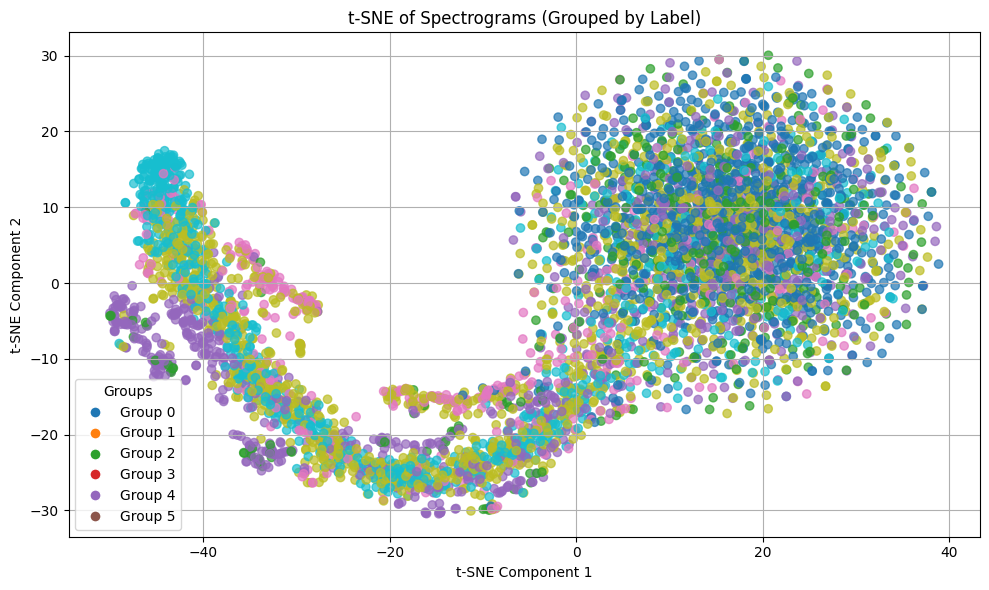

In [42]:
X_flat = X.reshape(X.shape[0], -1)

subset_size = 5000
idx = np.random.choice(len(X_flat), subset_size, replace=False)
X_sub = X_flat[idx]
y_sub = y[idx]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_sub)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1],
    c=y_sub, cmap='tab10', alpha=0.7
)

num_classes = len(np.unique(y_sub))
handles = [plt.Line2D([0], [0], marker='o', color='w',
                      label=f"Group {i}", markerfacecolor=plt.cm.tab10(i), markersize=8)
           for i in range(num_classes)]

plt.legend(handles=handles, title="Groups")
plt.title("t-SNE of Spectrograms (Grouped by Label)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


### Yikes!
It seems that our Spectrogram data, while certain groups (like group 4) are easily seperable & identifiable, is pretty muddy! 

Around half of our data seems easily seperable (with this protruding tail almost), and another half is just clumped into this messy, almost ball-like structure.

This suggests that there will most definitely be a data bottleneck we will experience with our spectrograms that any model architecture, no matter how complex, will not be able to solve😔.

This structure is not exclusive to spectrograms of dimensionality (17, 29), but similar patterns have been observed once spectrogram width had been cranked up. 

In [43]:
X_train, y_train, X_val, y_val, X_test, y_test = split_sets(X, y)

Train shape: (132000, 2, 17, 29), (132000,)
Validation shape: (44000, 2, 17, 29), (44000,)
Test shape: (44000, 2, 17, 29), (44000,)


In [44]:
LE = LabelEncoder()
y_train_enc = LE.fit_transform(y_train)
y_val_enc = LE.transform(y_val)
y_test_enc = LE.transform(y_test)
print(Counter(y_train_enc))
print(LE.classes_)

Counter({np.int64(4): 36000, np.int64(5): 24000, np.int64(2): 24000, np.int64(0): 24000, np.int64(3): 12000, np.int64(1): 12000})
[0 1 2 3 4 5]


In [45]:
X_spect_train = X_train.copy()
X_spect_val = X_val.copy()
X_spect_test = X_test.copy()

y_spect_train_enc = y_train_enc.copy()
y_spect_val_enc = y_val_enc.copy()
y_spect_test_enc = y_test_enc.copy()

In [46]:
train_dataset_spect = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train_enc, dtype=torch.long))
val_dataset_spect = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val_enc, dtype=torch.long))
test_dataset_spect = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test_enc, dtype=torch.long))

train_loader_spect = DataLoader(train_dataset_spect, batch_size=64, shuffle=True)
val_loader_spect = DataLoader(val_dataset_spect, batch_size=64, shuffle=False)
test_loader_spect = DataLoader(test_dataset_spect, batch_size=64, shuffle=False)

# SpectrogramModel: Transformer-Based Classification for Spectrograms
This model processes 2D spectrogram inputs using a Vision Transformer-inspired (ViT) architecture, tailored for time-frequency representations of radio signals. It breaks down into two major components:

### SpectrogramPatchEncoder
This module encodes spectrograms into a sequence of patch embeddings:

Patch Projection: A 2D convolution splits the spectrogram into non-overlapping patches of size (patch_size) and projects them into a higher-dimensional embed_dim space.

CLS Token: A learnable [CLS] token is prepended to the patch sequence to aggregate global information (standard in transformer architectures).

Positional Embedding: Learnable positional encodings are added to retain spatial structure lost during patch flattening.

This outputs a tensor of shape (batch_size, num_patches + 1, embed_dim), which is ready for transformer processing.

### SpectrogramModel
This is the full classification pipeline:

Patch Encoder: Converts raw spectrograms (B, 2, H, W) into a sequence of patch embeddings.

Transformer Encoder: A stack of 4 transformer layers processes the sequence. It uses:

8 attention heads

512-dimensional feedforward layers

Batch-first format for simplicity

Classification Head:

Uses the output of the CLS token (first token in the sequence)

Applies LayerNorm, dropout, and a final linear layer to output logits over num_classes.

### Why Does it Work?
This model treats spectrograms like images and leverages transformer attention to capture global, non-local signal patterns that traditional CNNs or RNNs might miss. It's particularly effective for learning temporal + frequency dependencies in a unified representation.

In [47]:
class SpectrogramPatchEncoder(nn.Module):
    def __init__(self, in_channels=2, patch_size=(1, 1), embed_dim=128, img_size=(17, 29)):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

    def forward(self, x):
        B = x.size(0)
        x = self.proj(x) 
        x = x.flatten(2).transpose(1, 2)

        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed

        return x

In [48]:
class SpectrogramModel(nn.Module):
    def __init__(self, in_channels=2, img_size=(17, 29), patch_size=(3, 3), embed_dim=256, num_classes=11):
        super().__init__()
        self.patch_encoder = SpectrogramPatchEncoder(
            in_channels=in_channels,
            patch_size=patch_size,
            embed_dim=embed_dim,
            img_size=img_size
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=8, dim_feedforward=512, batch_first=True),
            num_layers=4
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Dropout(0.5),
            nn.Linear(embed_dim, num_classes)
        )
    def forward(self, x):
        x = self.patch_encoder(x)
        x = self.transformer(x)
        x = x[:, 0]
        x = self.classifier(x)
        return x
        

In [49]:
classes = np.unique(y)
class_weights = torch.tensor([0.8, 1.4, 1.4, 1.8, 1, 1.3]) 
class_weights_tensor = class_weights.to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([0.8000, 1.4000, 1.4000, 1.8000, 1.0000, 1.3000])


### Now unlike our I/Q branch...

Our Spectrogram model uses fine-tuned weights (that I sadly had to find out from a multitutde of experiments😭)

Lower weight (0.8): For classes that were overrepresented or easy for the model to learn. Seen in AM, its' weights were tuned down so much because the model started to rely on it when it was unsure, which meant that the whole "cluster ball" of data you saw in the T-SNE 2D graph used to be predicted as ALL (or nearly all) class 0 before these custom weights were implemented. 

Higher weights (1.4–1.8): For underrepresented or visually ambiguous classes that the model struggled with (FM, PSK). Another justification for turning these weights up so much was also given that classes 3 & 4 didn't attract too many false positives when said values were increased, and net accuracy improved when class 2 weights were bumped up (despite siphoning from class 0). 

Weight of 1.0: For classes that were relatively balanced or neutral in terms of difficulty.

##### Now let's train!

In [29]:
Spectrogram_Model_V1 = SpectrogramModel(in_channels=2, img_size=(17, 29), patch_size=(3, 3), embed_dim=256,
                                                 num_classes=6).to(device)

#### A quick side note here
Some people might be wondering why a patch size of (3, 3) - relatively coarse, is being used in tandem with an already coarse spectrogram. 
    
However, it boils down to the same weird fact that testing accuracy didn't really improve with any more "fine" patch sizes. This heavily suggests that the reason for our accuracy "cap" is simply a data bottleneck. This presence of a data bottleneck is only further complimented by the fact that our T-SNE graph displayed the big "clump" it did, and than more intensive spectrogram resolutions didn't really generate much of a difference in accuracy terms. 

In [37]:
optimizer = optim.Adam(Spectrogram_Model_V1.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
train_losses_spect, val_losses_spect = train_model(model=Spectrogram_Model_V1, criterion=criterion, 
            optimizer=optimizer, epochs=15, train_loader=train_loader_spect, 
            val_loader=val_loader_spect, scheduler=scheduler)

Epoch 1/15 | Train Loss: 0.895035 | Val Loss: 0.902582


Epoch 2/15 | Train Loss: 0.893134 | Val Loss: 0.898658


Epoch 3/15 | Train Loss: 0.889476 | Val Loss: 0.897115


Epoch 4/15 | Train Loss: 0.888327 | Val Loss: 0.883916


Epoch 5/15 | Train Loss: 0.885298 | Val Loss: 0.895704


Epoch 6/15 | Train Loss: 0.882736 | Val Loss: 0.874611


Epoch 7/15 | Train Loss: 0.880644 | Val Loss: 0.878057


Epoch 8/15 | Train Loss: 0.878994 | Val Loss: 0.887210


Epoch 9/15 | Train Loss: 0.877777 | Val Loss: 0.900076


Epoch 10/15 | Train Loss: 0.878766 | Val Loss: 0.891925


Epoch 11/15 | Train Loss: 0.853334 | Val Loss: 0.866962


Epoch 12/15 | Train Loss: 0.850099 | Val Loss: 0.869323


Epoch 13/15 | Train Loss: 0.848224 | Val Loss: 0.866093


Epoch 14/15 | Train Loss: 0.846542 | Val Loss: 0.869464


Epoch 15/15 | Train Loss: 0.844778 | Val Loss: 0.869252


In [38]:
Spectrogram_Model_V1.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader_spect:
        X_batch = X_batch.to(device)
        outputs = Spectrogram_Model_V1(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

print(classification_report(y_true, y_pred, target_names=[str(c) for c in LE.classes_]))

              precision    recall  f1-score   support

           0       0.40      0.51      0.45      8000
           1       0.52      0.60      0.56      4000
           2       0.78      0.65      0.71      8000
           3       0.80      0.67      0.73      4000
           4       0.59      0.61      0.60     12000
           5       0.77      0.63      0.70      8000

    accuracy                           0.61     44000
   macro avg       0.64      0.61      0.62     44000
weighted avg       0.63      0.61      0.62     44000



Classification Report: Grouped Modulation (6 Classes)
This report summarizes the model’s performance after grouping the original 11 modulation classes into 6 broader categories. The model achieved an overall accuracy of 61 (With "luckier" starting weights, model accuracy has even reached 62), with fairly balanced performance across most classes.

Classes 2, 3, and 5 performed best, each achieving F1-scores around 0.70–0.73, indicating strong precision and recall.

Class 0 had the weakest performance (F1: 0.45), likely due to class overlap or label noise.

The macro and weighted F1-scores both hover around 0.62, showing the model maintains decent performance even with class imbalance.

Overall, this grouping strategy has significantly improved model generalization and reduced confusion, especially compared to the original 11-class configuration (Which had an accuracy of 51%!).

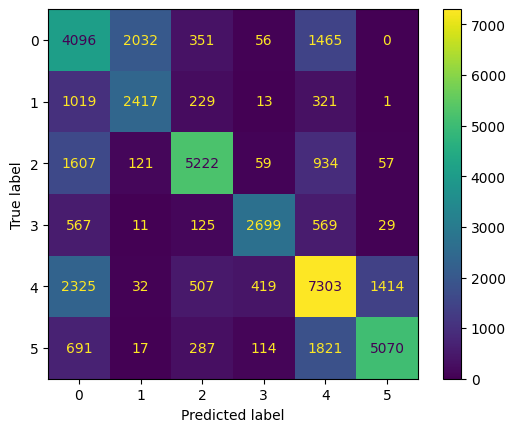

In [39]:
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=LE.classes_).plot()

### More specific training logs (for interested viewers): 
We trained a transformer-based model on spectrogram data using a patch encoder and 4-layer Transformer. Across various configurations—adjusting patch sizes, image dimensions, embedding sizes, and class weights, we consistently saw performance plateau around 50–51% accuracy, with the best model trained on spectrograms of size (17, 29). While early stopping and label smoothing helped stabilize training, architectural changes alone yielded limited improvement, suggesting a ceiling rooted more in data quality than model design.

To address this, we reduced the original 11 classes to 6 broader categories and adjusted class weights to counteract imbalance, ESPESCIALLY overprediction of class 4. This led to meaningful gains: the CNN reached 58%, and the transformer improved to 61% accuracy. However, despite dimensionality changes (e.g. (17, 125) or (33, 61)), overall accuracy remained relatively stable.

These trends HIGHLY suggest the primary bottleneck may lie in the inherent ambiguity between modulation types, rather than model limitations.

In [108]:
torch.save(Spectrogram_Model_V1.state_dict(), 'spect_model_full.pth')

In [50]:
class EchoScopeFusionModel(nn.Module):
    def __init__(self, ts_model: nn.Module, spec_model: nn.Module,
                 fused_hidden_dim=512, num_classes=6): 
        super().__init__()
        self.ts_branch = ts_model
        self.spec_branch = spec_model

        for param in self.ts_branch.parameters():
            param.requires_grad = False
        for param in self.spec_branch.parameters():
            param.requires_grad = False
            
        for param in self.ts_branch.fc1.parameters():
            param.requires_grad = True
        for param in self.spec_branch.transformer.parameters():
            param.requires_grad = True

        ts_output_dim = 256  
        spec_output_dim = spec_model.patch_encoder.embed_dim 

        self.cross_attn = nn.MultiheadAttention(embed_dim=ts_output_dim, num_heads=4)
        self.fusion = nn.Sequential(
            nn.Linear(ts_output_dim + spec_output_dim, fused_hidden_dim),
            nn.GELU(),  
            nn.BatchNorm1d(fused_hidden_dim),
            nn.Linear(fused_hidden_dim, fused_hidden_dim//2),
            nn.GELU(),
            nn.Dropout(0.3), 
            nn.Linear(fused_hidden_dim//2, num_classes)
        )
        
        self.ts_classifier = nn.Linear(ts_output_dim, num_classes)
        self.spec_classifier = nn.Linear(spec_output_dim, num_classes)

    def forward(self, ts_input, spec_input):
        ts_feat = self.ts_branch(ts_input)  
        spec_feat = self.spec_branch(spec_input)
        ts_q = ts_feat.unsqueeze(0)      
        spec_kv = spec_feat.unsqueeze(0)  
        attn_out, _ = self.cross_attn(query=ts_q, key=spec_kv, value=spec_kv)
        attn_out = attn_out.squeeze(0)  
        ts_feat = ts_feat + attn_out      
        fused = torch.cat([ts_feat, spec_feat], dim=1) 
        out = self.fusion(fused) 
        ts_out = self.ts_classifier(ts_feat)
        spec_out = self.spec_classifier(spec_feat)
        return out, ts_out, spec_out

In [29]:
class FusionDataset(Dataset):
    def __init__(self, ts_data, spec_data, labels):
        self.ts_data = torch.tensor(ts_data, dtype=torch.float32)
        self.spec_data = torch.tensor(spec_data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.ts_data[idx], self.spec_data[idx], self.labels[idx]

In [30]:
train_dataset_time = TensorDataset(torch.tensor(X_time_train, dtype=torch.float32),
                                   torch.tensor(y_time_train_enc, dtype=torch.long))

train_dataset_spect = TensorDataset(torch.tensor(X_spect_train, dtype=torch.float32),
                                    torch.tensor(y_spect_train_enc, dtype=torch.long))

In [31]:
assert np.array_equal(y_time_train_enc, y_spect_train_enc)
assert np.array_equal(y_train_enc, y_time_train_enc) 
print("First 5 encoded labels:", y_train_enc[:5])
print("Corresponding group names:", [LE.classes_[i] for i in y_train_enc[:5]])

First 5 encoded labels: [5 2 3 0 1]
Corresponding group names: [np.int64(5), np.int64(2), np.int64(3), np.int64(0), np.int64(1)]


In [32]:
fusion_train_dataset = FusionDataset(X_time_train, X_spect_train, y_train_enc)
fusion_val_dataset   = FusionDataset(X_time_val,   X_spect_val,   y_val_enc)
fusion_test_dataset  = FusionDataset(X_time_test,  X_spect_test,  y_test_enc)

fusion_train_loader = DataLoader(fusion_train_dataset, batch_size=64, shuffle=True)
fusion_val_loader   = DataLoader(fusion_val_dataset, batch_size=64, shuffle=False)
fusion_test_loader  = DataLoader(fusion_test_dataset, batch_size=64, shuffle=False)

In [33]:
ts_model_fusion = Time_Series_Model().to(device)
ts_model_fusion.fc2 = nn.Identity() 
ts_model_fusion.load_state_dict(torch.load('ts_model_full.pth'), strict=False)

<All keys matched successfully>

In [34]:
spect_model_fusion = SpectrogramModel(in_channels=2, img_size=(17, 29), patch_size=(3, 3), embed_dim=256,
                                                 num_classes=6).to(device)
spect_model_fusion.classifier = nn.Identity()
spect_model_fusion.load_state_dict(torch.load('spect_model_full.pth'), strict=False)

<All keys matched successfully>

In [35]:
Fusion_Model_V1 = EchoScopeFusionModel(ts_model_fusion, spect_model_fusion).to(device)

In [36]:
fusion_head_params = list(Fusion_Model_V1.fusion.parameters())
ts_branch_params = list(Fusion_Model_V1.ts_branch.parameters())
spec_branch_params = list(Fusion_Model_V1.spec_branch.parameters())

def criterion(outputs, targets):
    main_out, ts_out, spec_out = outputs
    loss = 0.6 * F.cross_entropy(main_out, targets) + \
           0.2 * F.cross_entropy(ts_out, targets) + \
           0.2 * F.cross_entropy(spec_out, targets)
    return loss

optimizer = torch.optim.AdamW([
    {'params': Fusion_Model_V1.fusion.parameters(), 'lr': 3e-4},
    {'params': Fusion_Model_V1.ts_branch.parameters(), 'lr': 1e-5},
    {'params': Fusion_Model_V1.spec_branch.parameters(), 'lr': 1e-5},
    {'params': Fusion_Model_V1.cross_attn.parameters(), 'lr': 1e-4}
], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

torch.nn.utils.clip_grad_norm_(Fusion_Model_V1.parameters(), max_norm=1.0)

tensor(0.)

In [37]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), 
    y=y_train
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [38]:
def train_fusion_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=50):
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_preds = []
        train_targets = []

        for ts_batch, spec_batch, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            ts_batch = ts_batch.to(device)
            spec_batch = spec_batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(ts_batch, spec_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            main_out, _, _ = outputs
            preds = main_out.argmax(dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_targets.extend(labels.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_acc = accuracy_score(train_targets, train_preds)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0
        val_preds = []
        val_targets = []

        with torch.no_grad():
            for ts_batch, spec_batch, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                ts_batch = ts_batch.to(device)
                spec_batch = spec_batch.to(device)
                labels = labels.to(device)

                outputs = model(ts_batch, spec_batch)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                main_out, _, _ = outputs
                preds = main_out.argmax(dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_acc = accuracy_score(val_targets, val_preds)
        val_losses.append(avg_val_loss)

        if scheduler is not None:
            scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, model

In [40]:
train_losses, val_losses, _ = train_fusion_model(Fusion_Model_V1, fusion_train_loader, fusion_val_loader, criterion, optimizer, 
                                                 scheduler, epochs=30)

Epoch 1/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 94.35it/s]


Epoch 1/30 | Train Loss: 1.0388 | Train Acc: 0.6979 | Val Loss: 1.0643 | Val Acc: 0.6708


Epoch 2/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 95.70it/s]


Epoch 2/30 | Train Loss: 0.9969 | Train Acc: 0.7024 | Val Loss: 1.0444 | Val Acc: 0.6728


Epoch 3/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 94.66it/s]


Epoch 3/30 | Train Loss: 0.9805 | Train Acc: 0.7037 | Val Loss: 1.0373 | Val Acc: 0.6685


Epoch 4/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 94.27it/s]


Epoch 4/30 | Train Loss: 0.9674 | Train Acc: 0.7051 | Val Loss: 1.0224 | Val Acc: 0.6718


Epoch 5/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 94.70it/s]


Epoch 5/30 | Train Loss: 0.9559 | Train Acc: 0.7048 | Val Loss: 1.0139 | Val Acc: 0.6718


Epoch 6/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 93.80it/s]


Epoch 6/30 | Train Loss: 0.9455 | Train Acc: 0.7051 | Val Loss: 0.9983 | Val Acc: 0.6727


Epoch 7/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 94.92it/s]


Epoch 7/30 | Train Loss: 0.9365 | Train Acc: 0.7064 | Val Loss: 0.9913 | Val Acc: 0.6742


Epoch 8/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 93.45it/s]


Epoch 8/30 | Train Loss: 0.9274 | Train Acc: 0.7060 | Val Loss: 0.9878 | Val Acc: 0.6741


Epoch 9/30 [Val]: 100%|██████████████████████| 688/688 [00:07<00:00, 94.04it/s]


Epoch 9/30 | Train Loss: 0.9186 | Train Acc: 0.7055 | Val Loss: 0.9771 | Val Acc: 0.6730


Epoch 10/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.81it/s]


Epoch 10/30 | Train Loss: 0.9097 | Train Acc: 0.7067 | Val Loss: 0.9773 | Val Acc: 0.6721


Epoch 11/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.49it/s]


Epoch 11/30 | Train Loss: 0.9019 | Train Acc: 0.7066 | Val Loss: 0.9760 | Val Acc: 0.6730


Epoch 12/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.44it/s]


Epoch 12/30 | Train Loss: 0.8950 | Train Acc: 0.7064 | Val Loss: 0.9598 | Val Acc: 0.6732


Epoch 13/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.66it/s]


Epoch 13/30 | Train Loss: 0.8889 | Train Acc: 0.7060 | Val Loss: 0.9484 | Val Acc: 0.6717


Epoch 14/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 92.72it/s]


Epoch 14/30 | Train Loss: 0.8814 | Train Acc: 0.7065 | Val Loss: 0.9553 | Val Acc: 0.6724


Epoch 15/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.56it/s]


Epoch 15/30 | Train Loss: 0.8763 | Train Acc: 0.7072 | Val Loss: 0.9427 | Val Acc: 0.6681


Epoch 16/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.67it/s]


Epoch 16/30 | Train Loss: 0.8704 | Train Acc: 0.7067 | Val Loss: 0.9389 | Val Acc: 0.6740


Epoch 17/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 95.12it/s]


Epoch 17/30 | Train Loss: 0.8651 | Train Acc: 0.7077 | Val Loss: 0.9429 | Val Acc: 0.6739


Epoch 18/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.55it/s]


Epoch 18/30 | Train Loss: 0.8605 | Train Acc: 0.7068 | Val Loss: 0.9263 | Val Acc: 0.6735


Epoch 19/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.18it/s]


Epoch 19/30 | Train Loss: 0.8557 | Train Acc: 0.7084 | Val Loss: 0.9274 | Val Acc: 0.6735


Epoch 20/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.89it/s]


Epoch 20/30 | Train Loss: 0.8519 | Train Acc: 0.7077 | Val Loss: 0.9216 | Val Acc: 0.6741


Epoch 21/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 92.87it/s]


Epoch 21/30 | Train Loss: 0.8477 | Train Acc: 0.7078 | Val Loss: 0.9198 | Val Acc: 0.6747


Epoch 22/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.51it/s]


Epoch 22/30 | Train Loss: 0.8454 | Train Acc: 0.7077 | Val Loss: 0.9190 | Val Acc: 0.6700


Epoch 23/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.62it/s]


Epoch 23/30 | Train Loss: 0.8416 | Train Acc: 0.7079 | Val Loss: 0.9091 | Val Acc: 0.6734


Epoch 24/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.59it/s]


Epoch 24/30 | Train Loss: 0.8385 | Train Acc: 0.7079 | Val Loss: 0.9118 | Val Acc: 0.6742


Epoch 25/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.15it/s]


Epoch 25/30 | Train Loss: 0.8353 | Train Acc: 0.7089 | Val Loss: 0.9110 | Val Acc: 0.6755


Epoch 26/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.84it/s]


Epoch 26/30 | Train Loss: 0.8339 | Train Acc: 0.7086 | Val Loss: 0.9058 | Val Acc: 0.6747


Epoch 27/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 94.21it/s]


Epoch 27/30 | Train Loss: 0.8313 | Train Acc: 0.7086 | Val Loss: 0.9086 | Val Acc: 0.6734


Epoch 28/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 92.76it/s]


Epoch 28/30 | Train Loss: 0.8296 | Train Acc: 0.7081 | Val Loss: 0.8996 | Val Acc: 0.6739


Epoch 29/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.48it/s]


Epoch 29/30 | Train Loss: 0.8273 | Train Acc: 0.7083 | Val Loss: 0.9076 | Val Acc: 0.6733


Epoch 30/30 [Val]: 100%|█████████████████████| 688/688 [00:07<00:00, 93.27it/s]

Epoch 30/30 | Train Loss: 0.8245 | Train Acc: 0.7085 | Val Loss: 0.9021 | Val Acc: 0.6716



Test Accuracy: 0.6757

 Classification Report:
              precision    recall  f1-score   support

           0     0.4063    0.8625    0.5524      8000
           1     0.6802    0.3690    0.4784      4000
           2     0.8509    0.6506    0.7374      8000
           3     0.9063    0.6793    0.7765      4000
           4     0.8004    0.6413    0.7121     12000
           5     0.9379    0.7173    0.8129      8000

    accuracy                         0.6757     44000
   macro avg     0.7637    0.6533    0.6783     44000
weighted avg     0.7616    0.6757    0.6906     44000



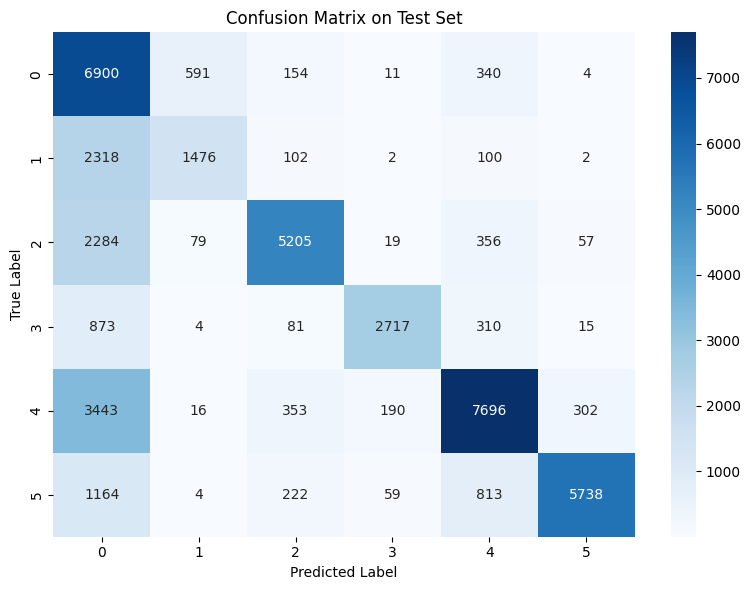

In [41]:
Fusion_Model_V1.eval()
Fusion_Model_V1.to(device)

all_preds = []
all_targets = []

with torch.no_grad():
    for ts_batch, spec_batch, labels in fusion_test_loader:
        ts_batch = ts_batch.to(device)
        spec_batch = spec_batch.to(device)
        labels = labels.to(device)

        outputs = Fusion_Model_V1(ts_batch, spec_batch)
        main_out, _, _ = outputs
        preds = main_out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

acc = accuracy_score(all_targets, all_preds)
print(f"\nTest Accuracy: {acc:.4f}")

print("\n Classification Report:")
print(classification_report(all_targets, all_preds, digits=4))

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

Initially, 75% train acc w/ 67% val/test acc. Done w/o class weights, 0.5 dropout, no label smoothing or weight decay. 

W/ class weights accuracy drops down to 66%. 

In [118]:
iq_example = np.load('./saved_samples/iq_samples/sample_0.npy')
spec_example = np.load('./saved_samples/spectrogram_samples/sample_0.npy')
print(iq_example.shape)
print(spec_example.shape)

(128, 2)
(2, 17, 29)


In [119]:
iq_tensor = torch.tensor(iq_example, dtype=torch.float32).unsqueeze(0).to(device)
spec_tensor = torch.tensor(spec_example, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  

In [120]:
print(iq_tensor.shape)
spec_tensor = spec_tensor.squeeze(0)
print(spec_tensor.shape)

torch.Size([1, 128, 2])
torch.Size([1, 2, 17, 29])


In [121]:
ts_model = Time_Series_Model()
ts_model.fc2 = nn.Identity()
ts_model.load_state_dict(torch.load("ts_model_full.pth"), strict=False)

spec_model = SpectrogramModel()
spec_model.classifier = nn.Identity()
spec_model.load_state_dict(torch.load("spect_model_full.pth"), strict=False)

fusion_model = EchoScopeFusionModel(ts_model, spec_model).to(device)
fusion_model.load_state_dict(torch.load("fusion_model_full.pth"), strict=False)
fusion_model.eval()

EchoScopeFusionModel(
  (ts_branch): Time_Series_Model(
    (lstm): LSTM(2, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=512, out_features=256, bias=True)
    (fc2): Identity()
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (spec_branch): SpectrogramModel(
    (patch_encoder): SpectrogramPatchEncoder(
      (proj): Conv2d(2, 256, kernel_size=(3, 3), stride=(3, 3))
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          

In [122]:
with torch.no_grad():
    fusion_output, ts_out, spec_out = fusion_model(iq_tensor, spec_tensor)

    logits = fusion_output.squeeze(0).cpu().numpy()
    probs = F.softmax(fusion_output, dim=1).squeeze(0).cpu().numpy()
    predicted_class = int(torch.argmax(fusion_output, dim=1).item())

    print("Predicted class index:", predicted_class)
    print("Logits:", np.round(logits, 3))
    print("Softmax probabilities:", np.round(probs, 3))

Predicted class index: 4
Logits: [-10.892 -11.894 -10.389  -8.583   4.84   -1.802]
Softmax probabilities: [0.    0.    0.    0.    0.999 0.001]
